In [ ]:
coord = 100,100,30
pad_width = [(0, max(0, coord[2-i] - slice.shape[i])) for i in range(3)]
p = np.pad(slice, pad_width=pad_width, mode='constant', constant_values=0)
np.all(p == slice)

True

In [22]:
from datatsets_peter import DICOMNodule, NRRDNodule,  ras_to_lps
nodule = DICOMNodule(
                         image_file_path="/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_35/",
                         center_lps=ras_to_lps([51.4106, -46.4581, -142.25])
)

In [23]:
import SimpleITK as sitk
nrrdnodule = NRRDNodule(image_file_path="test.nrrd", center_lps=ras_to_lps([51.4106, -46.4581, -142.25]))

In [ ]:
from datatsets_peter import *
from datasets import getCtRawNodule
infos = NoduleInfoGenerator()
infos.add_strategies(R17SampleGeneratorStrategy, PrasadSampleGeneratoryStrategy)
infos = infos.generate_all_samples()


AttributeError: module 'numpy' has no attribute 'typing'

In [19]:
# n = [n for n in infos if n.file_path == "/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_6"][0] # 257
infos = getNoduleInfoList()
n = [n for n in infos if n.nod_id == "RIA_17-353D_Prasad_000_76"][0]
nodule = n.image_type(n.file_path, n.center_lps)

2024-07-31 19:41:25,353 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 20
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 20
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 26
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 29
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 61
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 69
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 103
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 128


IndexError: list index out of range

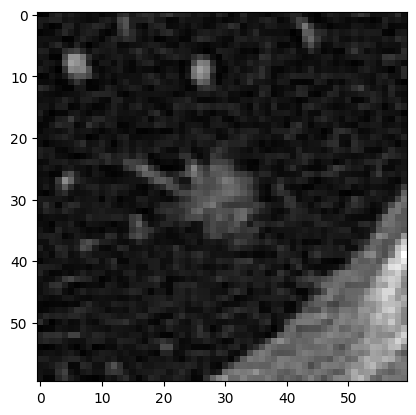

In [ ]:
import matplotlib.pyplot as plt
nod, _ = getCtRawNodule(n.file_path, n.image_type, n.center_lps, (60,60,60), False)
original, _ = nodule.nodule_slice(preprocess=False)
plt.imshow(original[30,:,:], cmap="gray")

Slice shape (60, 100, 100)


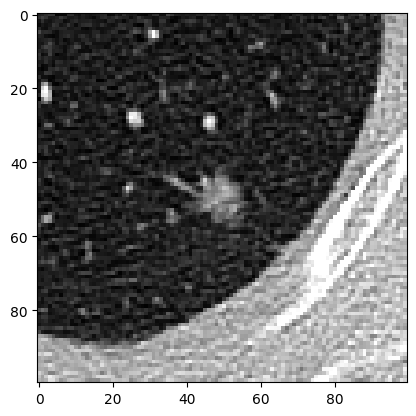

In [ ]:
print("Slice shape", sliced_arr.shape)
sliced_arr = np.clip(sliced_arr, -1400, 1400)
plt.imshow(sliced_arr[30,:,:], cmap="gray")

In [1]:
from datasets import getNoduleInfoList, slice_and_pad_segmentation, getCtRawNodule
noduleInfo_tup = getNoduleInfoList()[0]
width_irc = (40, 40, 30)
nodule_a, slice_3d = getCtRawNodule(
                noduleInfo_tup.file_path,
                noduleInfo_tup.image_type,
                noduleInfo_tup.center_lps,
                width_irc,
                preprocess=False
            )
nod_segmentation = slice_and_pad_segmentation("nodule", noduleInfo_tup, width_irc, slice_3d)

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 14:33:00,555 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 20
2024-08-01 14:33:00,557 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 20
2024-08-01 14:33:00,557 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 26
2024-08-01 14:33:00,558 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 29
2024-08-01 14:33:00,559 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 61
2024-08-01 14:33:00,559 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 69
2024-08-01 14:33:00,560 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 103
2024-08-01 14:33:00,561 INFO     pid:

In [1]:
from datasets import getNoduleInfoList
nods = getNoduleInfoList()

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 19:30:19,277 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 20
2024-08-01 19:30:19,277 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 20
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 26
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 29
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 61
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 69
2024-08-01 19:30:19,279 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 103
2024-08-01 19:30:19,279 INFO     pid:

In [2]:
len(nods)

109

In [8]:
from datasets import getNoduleInfoList
nods = getNoduleInfoList()
nod = [nod for nod in nods if nod.file_path == "/data/etay/lung_hist_dat/original_dat_nrrds/nod104.nrrd"][0]
nod_obj = nod.image_type(nod.file_path, nod.center_lps)
nodule_slice, slice_3d = nod_obj.nodule_slice(True, (50, 50, 50))

2024-08-22 18:19:13,633 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 5
2024-08-22 18:19:13,634 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 8
2024-08-22 18:19:13,635 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 15
2024-08-22 18:19:13,636 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 32
2024-08-22 18:19:13,636 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 33
2024-08-22 18:19:13,637 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 42
2024-08-22 18:19:13,637 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 61
2024-08-22 18:19:13,638 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 76
2024-08-22 18:19:13,638 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 82
2024-08-22 18:19:13,639 INFO     pid:3755346 datatsets_peter:190:generate_nodule_info EXCLUDING: 89
20

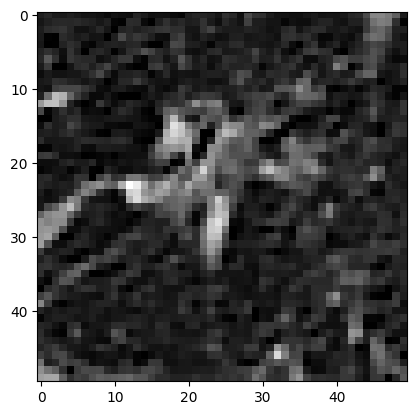

In [15]:
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
nodule = sitk.ReadImage("/data/etay/lung_hist_dat/original_dat_nrrds/nod104.nrrd")
# plt.imshow(sitk.GetArrayFromImage(nodule[slice_3d[::-1]])[20], cmap="grey")
plt.imshow(nodule_slice[20], cmap="grey")

In [1]:
from datasets import getNoduleInfoList, getCtRawNodule
nods = getNoduleInfoList()
nod = nods[0]


/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-25 21:11:42,887 INFO     pid:2393428 datatsets_peter:192:generate_nodule_info EXCLUDING: 5
2024-08-25 21:11:42,888 INFO     pid:2393428 datatsets_peter:192:generate_nodule_info EXCLUDING: 8
2024-08-25 21:11:42,889 INFO     pid:2393428 datatsets_peter:192:generate_nodule_info EXCLUDING: 15
2024-08-25 21:11:42,889 INFO     pid:2393428 datatsets_peter:192:generate_nodule_info EXCLUDING: 32
2024-08-25 21:11:42,890 INFO     pid:2393428 datatsets_peter:192:generate_nodule_info EXCLUDING: 33
2024-08-25 21:11:42,891 INFO     pid:2393428 datatsets_peter:192:generate_nodule_info EXCLUDING: 42
2024-08-25 21:11:42,892 INFO     pid:2393428 datatsets_peter:192:generate_nodule_info EXCLUDING: 61
2024-08-25 21:11:42,892 INFO     pid:239

In [3]:
# import matplotlib.pyplot as plt
# nodule_im = getCtRawNodule(nod.file_path, nod.image_type, nod.center_lps, False, 1, 64)
# plt.imshow(nodule_im[12], cmap="grey")
from ast import literal_eval
import csv
from dataclasses import dataclass
import functools
import logging
import os
import pickle
import random
from typing import Any, List, Optional, Tuple, Union
import SimpleITK as sitk
import numpy as np
from lungmask import LMInferer
import torchio as tio
import numpy.typing
label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
ct = nod.image_type(nod.file_path, nod.center_lps)

signed_distance_map = sitk.SignedMaurerDistanceMap(ct.nodule_segmentation(), squaredDistance=False, useImageSpacing=True)
dilated_binary_image = (signed_distance_map<5)
# arr = sitk.GetArrayFromImage(dilated_binary_image)
# np.where(arr == 1)
# plt.imshow(arr[186], cmap="grey")
# label_shape_filter.GetCentroid(1)
# plt.imshow(sitk.GetArrayFromImage(dilated_binary_image)[168], cmap="grey")
# plt.imshow(sitk.GetArrayFromImage(dilated_binary_image)[28], cmap="grey")
label_shape_filter.Execute(dilated_binary_image)
bounding_box = label_shape_filter.GetBoundingBox(1) 
p1 = dilated_binary_image.TransformIndexToPhysicalPoint(bounding_box[0 : int(len(bounding_box) / 2)])
p2 = dilated_binary_image.TransformIndexToPhysicalPoint([x+sz for x,sz in zip(bounding_box[0 : int(len(bounding_box) / 2)], bounding_box[int(len(bounding_box) / 2) :])])

# crop using the indexes computed for imgB
imgB_start_index = ct.image.TransformPhysicalPointToIndex(p1)
imgB_end_index = ct.image.TransformPhysicalPointToIndex(p2)
slicer = sitk.SliceImageFilter()
slicer.SetStart(imgB_start_index)
slicer.SetStop(imgB_end_index)
dilated_image = slicer.Execute(ct.image)
plt.imshow(sitk.GetArrayFromImage(dilated_image)[12], cmap="grey")
sitk.GetArrayFromImage(dilated_image).shape

NameError: name 'plt' is not defined

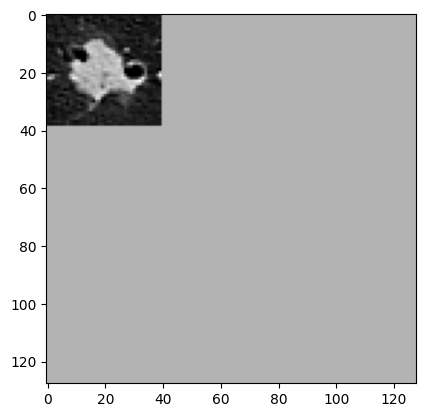

In [69]:
def resample_image(input_image: sitk.Image, output_size: int) -> sitk.Image:
    current_size = input_image.GetSize()
    # new_spacing = old_size * old_spacing / new_size 
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(input_image.GetSpacing())
    resample.SetSize([output_size]*3)
    resample.SetOutputDirection(input_image.GetDirection())
    resample.SetOutputOrigin(input_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(input_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(input_image)

r = resample_image(dilated_image, 128)
plt.imshow(sitk.GetArrayFromImage(r)[12], cmap="grey")

In [62]:
import matplotlib.pyplot as plt
import os
from datasets import getNoduleInfoList
import SimpleITK as sitk
import numpy as np 
nods = getNoduleInfoList()
nod = nods[0]
# QA Step: for all nodules, find the correct segmentation
# Returns either the np.array of the segmentation or None if it doesn't exist
excluded_nodules = []
taken = []
def exclude_non_segmented_nodules(nod):
    nod_id = os.path.basename(nod.file_path).split("nod")[1].split(".")[0]
    seg_file = f"/data/kaplinsp/test_nnunet/lung_{nod_id}.nii.gz"
    seg = sitk.ReadImage(seg_file)
    labeled_image = sitk.ConnectedComponent(seg)
    index = seg.TransformPhysicalPointToIndex(nod.center_lps)
    index_box = [slice(x-10, x+10) for x in index]
    center_box = sitk.GetArrayFromImage(labeled_image[index_box])
    segs = np.unique(center_box)
    
    # extract the segmentation for the nodule given center
    if len(segs) == 0 or len(segs) > 2 or (len(segs) == 1 and segs[0] == 0):
        excluded_nodules.append(nod.file_path)
        return 
    taken.append(nod.file_path)
    seg_id = int(np.max(segs))
    
    # nodule = sitk.BinaryThreshold(labeled_image, lowerThreshold=seg_id, upperThreshold=seg_id)
    # plt.imshow(sitk.GetArrayFromImage(nodule)[186], cmap="grey")

# exclude_non_segmented_nodules(nods[0])
for nod in nods:
    # if nod.file_path != '/data/etay/lung_hist_dat/original_dat_nrrds/nod103.nrrd':
    #     continue
    exclude_non_segmented_nodules(nod)
    

2024-08-26 14:09:57,445 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 5
2024-08-26 14:09:57,446 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 8
2024-08-26 14:09:57,447 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 15
2024-08-26 14:09:57,447 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 32
2024-08-26 14:09:57,448 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 33
2024-08-26 14:09:57,448 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 42
2024-08-26 14:09:57,449 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 61
2024-08-26 14:09:57,449 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 76
2024-08-26 14:09:57,450 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 82
2024-08-26 14:09:57,450 INFO     pid:2777012 datatsets_peter:192:generate_nodule_info EXCLUDING: 89
20

In [63]:

excluded_nodules

['/data/etay/lung_hist_dat/original_dat_nrrds/nod11.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod20.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod24.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod26.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod44.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod63.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod69.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod86.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod103.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod128.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod144.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod173.nrrd',
 '/data/etay/lung_hist_dat/original_dat_nrrds/nod178.nrrd']

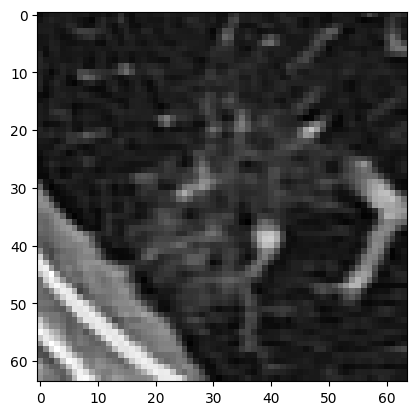

In [53]:
def resample_image(input_image: sitk.Image, output_size: int) -> sitk.Image:
    resample = sitk.ResampleImageFilter()
    original_size = input_image.GetSize()
    original_spacing = input_image.GetSpacing()
    # new_spacing = old_size * old_spacing / new_size 
    output_spacing = [
        original_size[i] * original_spacing[i] / output_size for i in range(len(original_size))
    ]
    resample.SetOutputSpacing(output_spacing)
    resample.SetSize([output_size]*3)
    resample.SetOutputDirection(input_image.GetDirection())
    resample.SetOutputOrigin(input_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(input_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(input_image)

r = resample_image(sliced_img, 64)
plt.imshow(sitk.GetArrayFromImage(r)[14], cmap="grey")

2024-08-26 14:19:41,669 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 11
2024-08-26 14:19:41,670 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 20
2024-08-26 14:19:41,671 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 20
2024-08-26 14:19:41,672 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 24
2024-08-26 14:19:41,672 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 26
2024-08-26 14:19:41,673 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 44
2024-08-26 14:19:41,673 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 61
2024-08-26 14:19:41,674 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 63
2024-08-26 14:19:41,675 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 63
2024-08-26 14:19:41,675 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 69
2024-08-26 14:19:41,676 INFO     pid:3137535 image:229:generate_nodule_info EXCLUDING: 86
2024-08-26

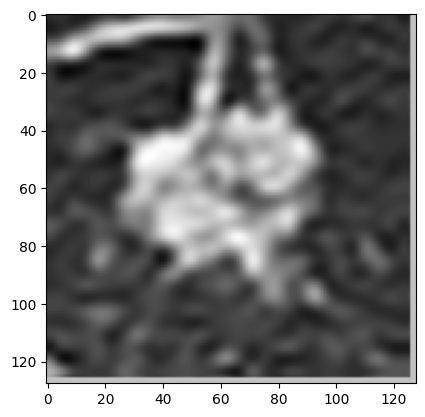

In [5]:
from datasets import getNoduleInfoList, getCtRawNodule
import matplotlib.pyplot as plt
l = getNoduleInfoList()
n = l[10]
nod = getCtRawNodule(n.file_path, n.image_type, n.center_lps, False, 5, 128)
plt.imshow(nod[60], cmap="grey")